In [1]:
%matplotlib inline

from datetime import datetime
tic = datetime.now()

import os
from os.path import dirname, abspath, join
from os import getcwd
import sys

# THIS_DIR = getcwd()
# CLASS_DIR = abspath(join(THIS_DIR, 'dsnclasses'))  #abspath(join(THIS_DIR, '../../..', 'dsnclasses'))
# sys.path.append(CLASS_DIR)

In [2]:
import random
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
from IPython.display import clear_output

In [3]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
class ENO(object):
    
    #no. of forecast types is 6 ranging from 0 to 5
  
    def __init__(self, location='tokyo', year=2010, shuffle=False, day_balance=False):
        self.location = location
        self.year = year
        self.day = None
        self.hr = None
        
        self.shuffle = shuffle
        self.day_balance = day_balance

        self.TIME_STEPS = None #no. of time steps in one episode
        self.NO_OF_DAYS = None #no. of days in one year
        
        self.NO_OF_DAYTYPE = 10 #no. of daytypes
        self.daycounter = 0 #to count number of days that have been passed
        
        self.sradiation = None #matrix with GSR for the entire year
        self.senergy = None #matrix with harvested energy data for the entire year
        self.fforecast = None #array with forecast values for each day
        

        self.henergy = None #harvested energy variable
        self.fcast = None #forecast variable
        self.sorted_days = [] #days sorted according to day type
        
        self.SMAX = 500*3# 1 Watt Solar Panel

    
    #function to get the solar data for the given location and year and prep it
    def get_data(self):
        #solar_data/CSV files contain the values of GSR (Global Solar Radiation in MegaJoules per meters squared per hour)
        #weather_data/CSV files contain the weather summary from 06:00 to 18:00 and 18:00 to 06:00+1
        location = self.location
        year = self.year

        THIS_DIR = getcwd()
        SDATA_DIR = abspath(join(THIS_DIR, 'solar_data'))  #abspath(join(THIS_DIR, '../../..', 'data'))
        
        sfile = SDATA_DIR + '/' + location +'/' + str(year) + '.csv'
        
        #skiprows=4 to remove unnecessary title texts
        #usecols=4 to read only the Global Solar Radiation (GSR) values
        solar_radiation = pd.read_csv(sfile, skiprows=4, encoding='shift_jisx0213', usecols=[4])
      
        #convert dataframe to numpy array
        solar_radiation = solar_radiation.values

        #convert missing data in CSV files to zero
        solar_radiation[np.isnan(solar_radiation)] = 0

        #reshape solar_radiation into no_of_daysx24 array
        solar_radiation = solar_radiation.reshape(-1,24)

        if(self.shuffle): #if class instatiation calls for shuffling the day order. Required when learning
            np.random.shuffle(solar_radiation) 
        self.sradiation = solar_radiation
        
        #GSR values (in MJ/sq.mts per hour) need to be expressed in mW
        # Conversion is accomplished by 
        # solar_energy = GSR(in MJ/m2/hr) * 1e6 * size of solar cell * efficiency of solar cell /(60x60) *1000 (to express in mW)
        # the factor of 2 in the end is assuming two solar cells
        self.senergy = 3*self.sradiation * 1e6 * (55e-3 * 70e-3) * 0.15 * 1000/(60*60)

        return 0
    
    #function to map total day radiation into type of day ranging from 0 to 5
    #the classification into day types is quite arbitrary. There is no solid logic behind this type of classification.
    
    def get_day_state(self,tot_day_radiation):
        bin_edges = np.array([0, 3.5, 6.5, 9.0, 12.5, 15.5, 18.5, 22.0, 25, 28])
        for k in np.arange(1,bin_edges.size):
            if (bin_edges[k-1] < tot_day_radiation <= bin_edges[k]):
                day_state = k -1
            else:
                day_state = bin_edges.size - 1
        return int(day_state)
    
    def get_forecast(self):
        #create a perfect forecaster.
        tot_day_radiation = np.sum(self.sradiation, axis=1) #contains total solar radiation for each day
        get_day_state = np.vectorize(self.get_day_state)
        self.fforecast = get_day_state(tot_day_radiation)
        
        #sort days depending on the type of day and shuffle them; maybe required when learning
        for fcast in range(0,6):
            fcast_days = ([i for i,x in enumerate(self.fforecast) if x == fcast])
            np.random.shuffle(fcast_days)
            self.sorted_days.append(fcast_days)
        return 0
    
    def reset(self,day=0): #it is possible to reset to the beginning of a certain day
        
        self.get_data() #first get data for the given year
        self.get_forecast() #calculate the forecast
        
        self.TIME_STEPS = self.senergy.shape[1]
        self.NO_OF_DAYS = self.senergy.shape[0]
        
        self.day = day
        self.hr = 0
        
        self.henergy = self.senergy[self.day][self.hr]
        self.fcast = self.fforecast[self.day]
        
        end_of_day = False
        end_of_year = False
        return [self.henergy, self.fcast, end_of_day, end_of_year]

    
    def step(self):
        end_of_day = False
        end_of_year = False
        if not(self.day_balance): #if daytype balance is not required
            if(self.hr < self.TIME_STEPS - 1):
                self.hr += 1
                self.henergy = self.senergy[self.day][self.hr] 
                self.fcast = self.fforecast[self.day]
            else:
                if(self.day < self.NO_OF_DAYS -1):
                    end_of_day = True
                    self.hr = 0
                    self.day += 1
                    self.henergy = self.senergy[self.day][self.hr] 
                    self.fcast = self.fforecast[self.day]
                else:
                    end_of_day = True
                    end_of_year = True
                    
        else: #when training, we want all daytypes to be equally represented for robust policy
              #obviously, the days are going to be in random order
            if(self.hr < self.TIME_STEPS - 1):
                self.hr += 1
                self.henergy = self.senergy[self.day][self.hr]
                self.fcast = self.fforecast[self.day]
            else:
                if(self.daycounter < self.NO_OF_DAYS -1):
                    end_of_day = True
                    self.daycounter += 1
                    self.hr = 0
                    daytype = random.choice(np.arange(0,self.NO_OF_DAYTYPE)) #choose random daytype
                    self.day = np.random.choice(self.sorted_days[daytype]) #choose random day from that daytype
                    self.henergy = self.senergy[self.day][self.hr] 
                    self.fcast = self.fforecast[self.day]
                else: 
                    end_of_day = True
                    end_of_year = True
                    self.daycounter = 0
        
        
        return [self.henergy, self.fcast, end_of_day, end_of_year]

In [5]:
class CAPM (object):
    def __init__(self,location='tokyo', year=2010, shuffle=False, trainmode=False):

        #all energy values i.e. BMIN, BMAX, BOPT, HMAX are in mWhr. Assuming one timestep is one hour
        
        self.BMIN = 0.0                #Minimum battery level that is tolerated. Maybe non-zero also
        self.BMAX = 9250.0            #Max Battery Level. May not necessarily be equal to total batter capacity [3.6V x 2500mAh]
        self.BOPT = 0.5 * self.BMAX    #Optimal Battery Level. Assuming 50% of battery is the optimum
        
        self.HMIN = 0      #Minimum energy that can be harvested by the solar panel.
        self.HMAX = None   #Maximum energy that can be harvested by the solar panel. [500mW]
        
        self.DMAX = 500      #Maximum energy that can be consumed by the node in one time step. [~ 3.6V x 135mA]
        self.N_ACTIONS = 10  #No. of different duty cycles possible
        self.DMIN = self.DMAX/self.N_ACTIONS #Minimum energy that can be consumed by the node in one time step. [~ 3.6V x 15mA]
        
        self.binit = None     #battery at the beginning of day
        self.btrack = []      #track the mean battery level for each day
        self.atrack = []      #track the duty cycles for each day
        self.batt = None      #battery variable
        self.enp = None       #enp at end of hr
        self.henergy = None   #harvested energy variable
        self.fcast = None     #forecast variable
        
        self.MUBATT = 0.6
        self.SDBATT = 0.02
        
        self.MUHENERGY = 0.5
        self.SDHENERGY = 0.2
        
        self.MUENP = 0
        self.SDENP = 0.02
        
        self.location = location
        self.year = year
        self.shuffle = shuffle
        self.trainmode = trainmode
        self.eno = None#ENO(self.location, self.year, shuffle=shuffle, day_balance=trainmode) #if trainmode is enable, then days are automatically balanced according to daytype i.e. day_balance= True
        
        self.day_violation_flag = False
        self.violation_flag = False
        self.violation_counter = 0

        self.NO_OF_DAYTYPE = 10 #no. of daytypes
 
    def reset(self,day=0,batt=-1):
        henergy, fcast, day_end, year_end = self.eno.reset(day) #reset the eno environment
        self.violation_flag = False
        self.violation_counter = 0
        if(batt == -1):
            self.batt = self.BOPT
        else:
            self.batt = batt
            
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX)
        self.binit = self.batt
        self.btrack = np.append(self.btrack, self.batt) #track battery levels

#         self.enp = self.BOPT - self.batt
        self.enp = self.binit - self.batt #enp is calculated
        self.henergy = np.clip(henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
        self.fcast = fcast
        
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/(self.NO_OF_DAYTYPE-1)

        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        reward = 0
        
        return [c_state, reward, day_end, year_end]
    
    def getstate(self): #query the present state of the system
        norm_batt = self.batt/self.BMAX - self.MUBATT
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/(self.NO_OF_DAYTYPE-1)        
        c_state = [norm_batt, norm_enp, norm_henergy] #continuous states

        return c_state
    
#     def rewardfn(self):
#         R_PARAM = 20000 #chosen empirically for best results
#         mu = 0
#         sig = 0.07*R_PARAM #knee curve starts at approx. 2000mWhr of deviation
#         norm_reward = 3*(np.exp(-np.power((self.enp - mu)/sig, 2.)/2) / np.exp(-np.power((0 - mu)/sig, 2.)/2))-1

        
# #         if(np.abs(self.enp) <= 0.12*R_PARAM):
# #             norm_reward = 2*(np.exp(-np.power((self.enp - mu)/sig, 2.)/2) / np.exp(-np.power((0 - mu)/sig, 2.)/2))
# #         else:
# #             norm_reward = -0.25 - 10*np.abs(self.enp/R_PARAM)
#         if(self.day_violation_flag):
#             norm_reward -= 3
            
#         return (norm_reward)
        
    
    #reward function
    def rewardfn(self):
        
        #FIRST REWARD AS A FUNCTION OF DRIFT OF BMEAN FROM BOPT i.e. in terms of BDEV = |BMEAN-BOPT|/BMAX
        bmean = np.mean(self.btrack)
        bdev = np.abs(self.BOPT - bmean)/self.BMAX
        # based on the sigmoid function
        # bdev ranges from bdev = (0,0.5) of BMAX
        p1_sharpness = 10
        n1_sharpness = 20
        shift1 = 0.5
        # r1(x) = 0.5 when x = 0.25. 
        # Therefore, shift = 0.5 to make sure that (2*x-shift) evaluates to zero at x = 0.25

        if(bdev<=0.25): 
            r1 = 2*(1-(1 / (1 + np.exp(-p1_sharpness*(2*bdev-shift1)))))-1
        else: 
            r1 = 2*(1-(1 / (1 + np.exp(-n1_sharpness*(2*bdev-shift1)))))-1
        # r1 ranges from -1 to 1
            
        #SECOND REWARD AS A FUNCTION OF ENP AS LONG AS BMAX/4 <= batt <= 3*BMAX/4 i.e. bdev <= 0.25
        if(bdev <=0.25):
            # enp ranges from enp = (0,3) of DMAX
            p2_sharpness = 2
            n2_sharpness = 2
            shift2 = 6    
            # r1(x) = 0.5 when x = 2. 
            # Therefore, shift = 6 to make sure that (3*x-shift) evaluates to zero at x = 2
#             print('Day energy', np.sum(self.eno.senergy[self.eno.day]))
#             print('Node energy', np.sum(self.atrack)*self.DMAX/self.N_ACTIONS)
#             x = np.abs(np.sum(self.eno.senergy[self.eno.day])-np.sum(self.atrack)*self.DMAX/self.N_ACTIONS )/self.DMAX
            x = np.abs(self.enp/self.DMAX)
            if(x<=2): 
                r2 = (1 / (1 + np.exp(p2_sharpness*(3*x-shift2))))
            else: 
                r2 = (1 / (1 + np.exp(n2_sharpness*(3*x-shift2))))
        else:
            r2 = 0 # if mean battery lies outside bdev limits, then enp reward is not considered.
        # r2 ranges from 0 to 1

        #REWARD AS A FUNCTION OF BATTERY VIOLATIONS
        if(self.day_violation_flag):
            violation_penalty = 3
        else:
            violation_penalty = 0 #penalty for violating battery limits anytime during the day
        
#         print("Reward ", (r1 + r2 - violation_penalty), '\n')
        return (r1*(2**r2) - violation_penalty)
    
    def step(self, action):
        day_end = False
        year_end = False
        self.violation_flag = False
        reward = 0
       
        action = np.clip(action, 0, self.N_ACTIONS-1) #action values range from (0 to N_ACTIONS-1)
        self.atrack = np.append(self.atrack, action+1) #track duty cycles
        e_consumed = (action+1)*self.DMAX/self.N_ACTIONS   #energy consumed by the node
        
        self.batt += (self.henergy - e_consumed)
        if(self.batt < 0.02*self.BMAX or self.batt > 0.98*self.BMAX ):
            self.violation_flag = True #penalty for violating battery limits everytime it happens
            reward = -2
        if(self.batt < 0.02*self.BMAX):
            reward -= 2
            
        if(self.violation_flag):
            if(self.day_violation_flag == False): #penalty for violating battery limits anytime during the day - triggers once everyday
                self.violation_counter += 1
                self.day_violation_flag = True
            
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX) #clip battery values within permitted level
        self.btrack = np.append(self.btrack, self.batt) #track battery levels

#         self.enp = self.BOPT - self.batt 
        self.enp = self.binit - self.atrack.sum()*self.DMAX/self.N_ACTIONS
        
        #proceed to the next time step
        self.henergy, self.fcast, day_end, year_end = self.eno.step()
        self.henergy = np.clip(self.henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
                
        if(day_end): #if eno object flags that the day has ended then give reward
            reward += self.rewardfn()
             
            if (self.trainmode): #reset battery to optimal level if limits are exceeded when training
#                 self.batt = np.random.uniform(self.DMAX*self.eno.TIME_STEPS/self.BMAX,0.8)*self.BMAX
#                 if (self.violation_flag):
                if np.random.uniform() < HELP : #occasionaly reset the battery
                    self.batt = self.BOPT  
            
            self.day_violation_flag = False
            self.binit = self.batt #this will be the new initial battery level for next day
            self.btrack = [] #clear battery tracker
            self.atrack = [] #clear duty cycle tracker
            
                    
                
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/(self.NO_OF_DAYTYPE-1)

        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        return [c_state, reward, day_end, year_end]

In [6]:
# Hyper Parameters
BATCH_SIZE = 32
LR = 0.0001          # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
LAMBDA = 0.9                # parameter decay
TARGET_REPLACE_ITER = 24*7*4*18    # target update frequency (every two months)
MEMORY_CAPACITY     = 24*7*4*12*2      # store upto six month worth of memory   

N_ACTIONS = 10 #no. of duty cycles (0,1,2,3,4)
N_STATES = 4 #number of state space parameter [batt, enp, henergy, fcast]

HIDDEN_LAYER = 50
NO_OF_ITERATIONS = 50
GPU = False
HELP = 0.05

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

#Class definitions for NN model and learning algorithm
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)
        
        self.fc2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        nn.init.xavier_uniform_(self.fc2.weight)
        
        self.fc3 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc3.weight)

        self.out = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.out.weight) 

    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value
    
class DQN(object):
    def __init__(self):
        if(GPU): 
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            device = torch.device('cpu')
        self.eval_net, self.target_net = Net(), Net()
        self.eval_net.to(device)
        self.target_net.to(device)
        self.device = device
#         print("Neural net")
#         print(self.eval_net)
        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory [mem: ([s], a, r, [s_]) ]
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR, weight_decay=1e-3)
        self.loss_func = nn.MSELoss()
        self.nettoggle = False

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        x = x.to(self.device)

        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            actions_value = actions_value.to(torch.device("cpu"))
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        x = x.to(self.device)

        # input only one sample
        if True:   # greedy
            actions_value = self.eval_net.forward(x)
            actions_value = actions_value.to(torch.device("cpu"))
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] # return the argmax index
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1
    
    def store_day_transition(self, transition_rec):
        data = transition_rec
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory= np.insert(self.memory, index, data,0)
        self.memory_counter += transition_rec.shape[0]

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
            self.nettoggle = not self.nettoggle
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])
        
        b_s = b_s.to(self.device)
        b_a = b_a.to(self.device)
        b_r = b_r.to(self.device)
        b_s_ = b_s_.to(self.device)

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [8]:
def stdize(s):
    MU_BATT = 0.5
    SD_BATT = 0.15
    
    MU_ENP = 0
    SD_ENP = 0.15
    
    MU_HENERGY = 0.35
    SD_HENERGY = 0.25
    
    MU_FCAST = 0.42
    SD_FCAST = 0.27
    
    norm_batt, norm_enp, norm_henergy, norm_fcast = s
    
    std_batt = (norm_batt - MU_BATT)/SD_BATT
    std_enp = (norm_enp - MU_ENP)/SD_ENP
    std_henergy = (norm_henergy - MU_HENERGY)/SD_HENERGY
    std_fcast = (norm_fcast - MU_FCAST)/SD_FCAST


    return [std_batt, std_enp, std_henergy, std_fcast]


In [9]:
#TRAIN 
dqn = DQN()
# for recording weights
oldfc1 = dqn.eval_net.fc1.weight.data.cpu().numpy().flatten()
old2fc1 = oldfc1

oldfc2 = dqn.eval_net.fc2.weight.data.cpu().numpy().flatten()
old2fc2 = oldfc2

# oldfc3 = dqn.eval_net.fc3.weight.data.cpu().numpy().flatten()
# old2fc3 = oldfc3

oldout = dqn.eval_net.out.weight.data.cpu().numpy().flatten()
old2out = oldout
########################################

best_iteration = -1
best_avg_reward = -1000 #initialize best average reward to very low value
reset_counter = 0 #count number of times the battery had to be reset
change_hr = 0
# PFILENAME = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(8)) #create random filename
# BFILENAME = "best"+PFILENAME + ".pt" #this file stores the best model
# TFILENAME = "terminal"+PFILENAME + ".pt" #this file stores the last model

avg_reward_rec = [] #record the yearly average rewards over the entire duration of training
violation_rec = []
print('\nTRAINING IN PROGRESS\n')
print('Device: ', dqn.device)

for iteration in range(NO_OF_ITERATIONS):
#     counter = iteration%10
#     EPSILON = 0.5*counter/(counter+1) + 0.5#sawtooth learning rate for disruptive learning
    print('EPSILON = {:.2}'.format(EPSILON))
    LOCATION = 'tokyo'#random.choice(['tokyo','wakkanai','minamidaito'])
    YEAR = random.choice(np.arange(2000,2010))
    capm = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
    capm.eno = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object
#     clear_output()
    print('\nIteration {}:  {}, {} '.format(iteration, LOCATION.upper(), YEAR))

    s, r, day_end, year_end = capm.reset()
    yr_record = np.empty(4)

    record = np.empty(4) #record for battery, henergy, reward and action
    transition_rec = np.zeros((capm.eno.TIME_STEPS, N_STATES * 2 + 2)) #record all the transition in one day

    while True:
        a = dqn.choose_action(stdize(s))

        # present state = [batt, enp, henergy]
        record = np.vstack((record, [s[0],s[2],r, a])) # record battery, henergy, reward and action for troubleshooting
        yr_record = np.vstack((yr_record, [s[0],s[2],r, a]))

        # take action
        s_, r, day_end, year_end = capm.step(a)
        
        temp_transitions = np.hstack((stdize(s), [a, r], stdize(s_)))
        transition_rec[capm.eno.hr-1,:] = temp_transitions

        if (day_end):
            transition_rec[:,5] += r #broadcast reward to all states
            decay_factor = [i for i in (LAMBDA**n for n in reversed(range(0, capm.eno.TIME_STEPS)))]
            transition_rec[:,5] = transition_rec[:,5] * decay_factor #decay reward proportionately
            dqn.store_day_transition(transition_rec)

        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()

        if dqn.nettoggle:
            change_hr = capm.eno.day*24+capm.eno.hr #to mark when the DQN is updated.
            dqn.nettoggle = not dqn.nettoggle

        if (year_end):
            break

        # transition to new state
        s = s_

    record = np.delete(record, 0, 0) #remove the first row which is garbage
    reward_rec = record[:,2] #extract reward information from the record array
    reward_rec = reward_rec[::24] #only consider terminal rewards
    print("Average Reward \t\t= {:.3f}".format(np.mean(reward_rec)))
    print("Violation Counter \t= {}".format(capm.violation_counter))
    
    # Log the average reward in avg_reward_rec
    avg_reward_rec = np.append(avg_reward_rec, np.mean(reward_rec))
    violation_rec = np.append(violation_rec, capm.violation_counter)

#     if(best_avg_reward < np.mean(reward_rec)):
#         best_avg_reward = np.mean(reward_rec)
    
#     if(best_avg_reward > 1.5 or iteration > 20):
#         EPSILON = 0.9
#         LR = 0.01
        
#     if (capm.violation_counter < 5):
#         reset_flag = False
#         EPSILON = 0.95
#         LR = 0.001
        

#     # Check if reward beats the High Score and possible save it    
#     if (iteration > 19): #save the best models only after 20 iterations
#         print("Best Score \t = {:8.3f} @ Iteration No. {}".format(best_avg_reward, best_iteration))
#         if(best_avg_reward < np.mean(reward_rec)):
#             best_iteration = iteration
#             best_avg_reward = np.mean(reward_rec)
#             print("Saving Model")
#             torch.save(dqn.eval_net.state_dict(), BFILENAME)
#     else:
#         print("\r")

   
    
###########################################################################################
# #   PLOT battery levels, hourly rewards and the weights
#     yr_record = np.delete(yr_record, 0, 0) #remove the first row which is garbage
# #     NO_OF_DAYS = capm.eno.NO_OF_DAYS
#     hourly_yr_reward_rec = yr_record[:,2]
#     yr_reward_rec = hourly_yr_reward_rec[::24]

    
#     fig = plt.figure(figsize=(24,3))
#     TIME_STEPS = capm.eno.TIME_STEPS
#     NO_OF_DAYS = capm.eno.NO_OF_DAYS
#     DAY_SPACING = 15
#     TICK_SPACING = TIME_STEPS*DAY_SPACING
#     #plot battery
#     ax = fig.add_subplot(111)
#     ax.plot(np.arange(0,TIME_STEPS*NO_OF_DAYS),yr_record[:,0],'r')
#     ax.set_ylim([0,1])
#     ax.axvline(x=change_hr)
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(TICK_SPACING))
# #     labels = [item for item in ax.get_xticklabels()]
# #     print(labels)
# #     labels [15:-1] = np.arange(0,NO_OF_DAYS,DAY_SPACING) #the first label is reserved to negative values
# #     ax.set_xticklabels(labels)
#     #plot hourly reward
#     ax0 = ax.twinx()
#     ax0.plot(hourly_yr_reward_rec, color='m')
#     ax0.set_ylim(-7,3)
#     plt.show()


#     fig = plt.figure(figsize=(18,3))
#     ax1 = fig.add_subplot(131)
#     newfc1 = dqn.eval_net.fc1.weight.data.cpu().numpy().flatten()
#     ax1.plot(old2fc1,color='b', alpha=0.4)
#     ax1.plot(oldfc1,color='b',alpha = 0.7)
#     ax1.plot(newfc1,color='b')
#     old2fc1 = oldfc1
#     oldfc1 = newfc1
    
#     ax2 = fig.add_subplot(132)
#     newfc2 = dqn.eval_net.fc2.weight.data.cpu().numpy().flatten()
#     ax2.plot(old2fc2,color='y', alpha=0.4)
#     ax2.plot(oldfc2,color='y',alpha = 0.7)
#     ax2.plot(newfc2,color='y')
#     old2fc2 = oldfc2
#     oldfc2 = newfc2
    
# #     ax3 = fig.add_subplot(143)
# #     newfc3 = dqn.eval_net.fc3.weight.data.cpu().numpy().flatten()
# #     ax3.plot(old2fc3,color='y', alpha=0.4)
# #     ax3.plot(oldfc3,color='y',alpha = 0.7)
# #     ax3.plot(newfc3,color='y')
# #     old2fc3 = oldfc3
# #     oldfc3 = newfc3
    
#     axO = fig.add_subplot(133)
#     newout = dqn.eval_net.out.weight.data.cpu().numpy().flatten()
#     axO.plot(old2out,color='g', alpha=0.4)
#     axO.plot(oldout,color='g',alpha=0.7)
#     axO.plot(newout,color='g')
#     old2out = oldout
#     oldout = newout
    
#     fig.tight_layout()
#     plt.show()


    # End of training


TRAINING IN PROGRESS

Device:  cpu
EPSILON = 0.9

Iteration 0:  TOKYO, 2008 
Average Reward 		= -6.479
Violation Counter 	= 349
EPSILON = 0.9

Iteration 1:  TOKYO, 2003 
Average Reward 		= -6.368
Violation Counter 	= 352
EPSILON = 0.9

Iteration 2:  TOKYO, 2008 
Average Reward 		= -3.702
Violation Counter 	= 280
EPSILON = 0.9

Iteration 3:  TOKYO, 2002 
Average Reward 		= -2.378
Violation Counter 	= 216
EPSILON = 0.9

Iteration 4:  TOKYO, 2003 
Average Reward 		= 0.053
Violation Counter 	= 90
EPSILON = 0.9

Iteration 5:  TOKYO, 2009 
Average Reward 		= 0.254
Violation Counter 	= 81
EPSILON = 0.9

Iteration 6:  TOKYO, 2007 
Average Reward 		= 0.186
Violation Counter 	= 84
EPSILON = 0.9

Iteration 7:  TOKYO, 2000 
Average Reward 		= 0.375
Violation Counter 	= 72
EPSILON = 0.9

Iteration 8:  TOKYO, 2007 
Average Reward 		= 0.348
Violation Counter 	= 71
EPSILON = 0.9

Iteration 9:  TOKYO, 2007 
Average Reward 		= 0.673
Violation Counter 	= 52
EPSILON = 0.9

Iteration 10:  TOKYO, 2000 
Ave

In [10]:
#END OF TRAINING PHASE - CHOOSING THE BEST MODEL INSTANCE
#INCREASE GREEDY RATE
#VALIDATE AFTER EVERY ITERATION

# Use this model and its output as base standards for the last phase of training
best_avg_avg_reward = -1000
best_net_avg_reward = dqn.eval_net
best_avg_v_counter = 1000
best_net_v_counter = dqn.eval_net


NO_OF_LAST_PHASE_ITERATIONS = 10
EPSILON = 0.95
print("EPSILON = ", EPSILON)
print("LR      = ", LR)

for iteration in range(NO_OF_LAST_PHASE_ITERATIONS):
    LOCATION = 'tokyo'#random.choice(['tokyo','wakkanai','minamidaito'])
    YEAR = random.choice(np.arange(2000,2010))
    capm = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
    capm.eno = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

    print('\nLAST PHASE ITERATION #{}:  {}, {} '.format(iteration, LOCATION.upper(), YEAR))
    
    
    my_avg_reward = -1000
    my_v_counter = 1000
    
    s, r, day_end, year_end = capm.reset()
    yr_record = np.empty(4)

    record = np.empty(4) #record for battery, henergy, reward and action
    transition_rec = np.zeros((capm.eno.TIME_STEPS, N_STATES * 2 + 2)) #record all the transition in one day

    while True:
        a = dqn.choose_action(stdize(s))

        # present state = [batt, enp, henergy]
        record = np.vstack((record, [s[0],s[2],r, a])) # record battery, henergy, reward and action for troubleshooting
        yr_record = np.vstack((yr_record, [s[0],s[2],r, a]))

        # take action
        s_, r, day_end, year_end = capm.step(a)
        
        temp_transitions = np.hstack((stdize(s), [a, r], stdize(s_)))
        transition_rec[capm.eno.hr-1,:] = temp_transitions

        if (day_end):
            transition_rec[:,5] += r #broadcast reward to all states
            decay_factor = [i for i in (LAMBDA**n for n in reversed(range(0, capm.eno.TIME_STEPS)))]
            transition_rec[:,5] = transition_rec[:,5] * decay_factor #decay reward proportionately
            dqn.store_day_transition(transition_rec)

        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()

        if dqn.nettoggle:
            change_hr = capm.eno.day*24+capm.eno.hr #to mark when the DQN is updated.
            dqn.nettoggle = not dqn.nettoggle

        if (year_end):
            break

        # transition to new state
        s = s_

    record = np.delete(record, 0, 0) #remove the first row which is garbage
    reward_rec = record[:,2] #extract reward information from the record array
    reward_rec = reward_rec[::24] #only consider terminal rewards
    print("Average Reward \t\t= {:.3f}".format(np.mean(reward_rec)))
    print("Violation Counter \t= {}".format(capm.violation_counter))
    
     # Log the average reward in avg_reward_rec
    avg_reward_rec = np.append(avg_reward_rec, np.mean(reward_rec))
    violation_rec = np.append(violation_rec, capm.violation_counter)
    
    print("***MEASURING PERFORMANCE OF THE MODEL***")
    print("\tBEST AVERAGE ANNUAL AVERAGE REWARD = {:.3f}".format(best_avg_avg_reward))
    print("\tBEST TOTAL VIOLATIONS              = {}".format(best_avg_v_counter))
    LOCATION = 'tokyo'
    results = np.empty(3)
    for YEAR in np.arange(2010,2015):
        capm = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
        capm.eno = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
        capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

        s, r, day_end, year_end = capm.reset()
        yr_test_record = np.empty(4)

        while True:
            a = dqn.choose_greedy_action(stdize(s))
            #state = [batt, enp, henergy, fcast]
            yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action
            # take action
            s_, r, day_end, year_end = capm.step(a)
            if year_end:
                break
            s = s_

        yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage
        yr_test_reward_rec = yr_test_record[:,2]
        yr_test_reward_rec = yr_test_reward_rec[::24] #annual average reward
        results = np.vstack((results, [int(YEAR), np.mean(yr_test_reward_rec), int(capm.violation_counter)]))
    results = np.delete(results,0,0)
    my_avg_reward = np.mean(results[:,1]) #the average of annual average rewards
    my_v_counter = np.sum(results[:,-1]) #total sum of violations
    print("\n\tAverage Annual Average Reward      = {:.3f}".format(my_avg_reward))
    print("\tTotal Violations                   = {}".format(my_v_counter))

    if (my_avg_reward > best_avg_avg_reward):
            best_avg_avg_reward = my_avg_reward
            best_net_avg_reward = dqn.eval_net

    if (my_v_counter < best_avg_v_counter):
        best_avg_v_counter = my_v_counter
        best_net_v_counter = dqn.eval_net
    elif (my_v_counter == best_avg_v_counter):
        if (my_avg_reward > best_avg_avg_reward):
            best_avg_v_counter = my_v_counterO
            best_net_v_counter = dqn.eval_net
    print("****************************************")

    


    

EPSILON =  0.95
LR      =  0.0001

LAST PHASE ITERATION #0:  TOKYO, 2000 
Average Reward 		= 0.901
Violation Counter 	= 36
***MEASURING PERFORMANCE OF THE MODEL***
	BEST AVERAGE ANNUAL AVERAGE REWARD = -1000.000
	BEST TOTAL VIOLATIONS              = 1000

	Average Annual Average Reward      = 1.004
	Total Violations                   = 168.0
****************************************

LAST PHASE ITERATION #1:  TOKYO, 2004 
Average Reward 		= 0.796
Violation Counter 	= 47
***MEASURING PERFORMANCE OF THE MODEL***
	BEST AVERAGE ANNUAL AVERAGE REWARD = 1.004
	BEST TOTAL VIOLATIONS              = 168.0

	Average Annual Average Reward      = 0.891
	Total Violations                   = 219.0
****************************************

LAST PHASE ITERATION #2:  TOKYO, 2008 
Average Reward 		= 1.125
Violation Counter 	= 21
***MEASURING PERFORMANCE OF THE MODEL***
	BEST AVERAGE ANNUAL AVERAGE REWARD = 1.004
	BEST TOTAL VIOLATIONS              = 168.0

	Average Annual Average Reward      = 1.001
	Tot

In [11]:
print('Device: ', dqn.device)
print('Train time: {}'.format(datetime.now() - tic))

Device:  cpu
Train time: 0:21:24.855355


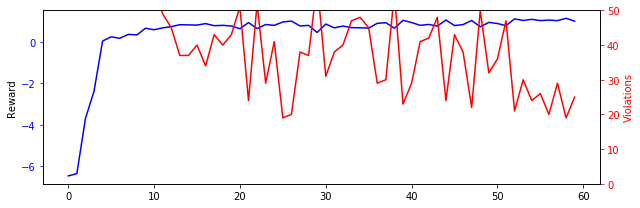

In [12]:
fig = plt.figure(figsize=(9,3))
# Plot the average reward log

ax1 = fig.add_subplot(111)
ax1.set_ylabel("Reward")
# ax1.set_ylim([-3,3]);
ax1.plot(avg_reward_rec,'b')
ax1.tick_params(axis='y', colors='b')

#Plot the violation record log
ax2 = ax1.twinx()
ax2.set_ylabel("Violations",color = 'r')
ax2.plot(violation_rec,'r')
for xpt in np.argwhere(violation_rec<1):
    ax2.axvline(x=xpt,color='g')
ax2.set_ylim([0,50]);
ax2.tick_params(axis='y', colors='r')

fig.tight_layout()

In [13]:
dqn.eval_net = best_net_avg_reward
torch.save(dqn.eval_net.state_dict(), 'C_SEED_0.pt')

In [14]:
#TESTING BEST MODEL BASED ON AVERAGE REWARD METRIC
dqn = DQN()
dqn.eval_net = best_net_avg_reward
LOCATION = 'tokyo'
results = np.empty(3)
for YEAR in np.arange(2000,2019):
    capm = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
    capm.eno = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

    s, r, day_end, year_end = capm.reset()
    yr_test_record = np.empty(4)

    while True:
        a = dqn.choose_greedy_action(stdize(s))

        #state = [batt, enp, henergy, fcast]
        yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

        # take action
        s_, r, day_end, year_end = capm.step(a)

        if year_end:
            break

        s = s_

    yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage

#     #Plot the reward and battery for the entire year run
#     title = LOCATION.upper() + ',' + str(YEAR)

#     NO_OF_DAYS = capm.eno.NO_OF_DAYS
    yr_test_reward_rec = yr_test_record[:,2]
    yr_test_reward_rec = yr_test_reward_rec[::24]
#     print('Average Reward for',title, '=', np.mean(yr_test_reward_rec))
#     print('Violations for',title, '=', capm.violation_counter)
    
    results = np.vstack((results, [int(YEAR), np.mean(yr_test_reward_rec), int(capm.violation_counter)]))

#     fig = plt.figure(figsize=(24,3))
#     fig.suptitle(title, fontsize=15)

    #     ax1 = fig.add_subplot(211)
    #     ax1.plot(yr_test_reward_rec)
    #     ax1.set_title("\n\nYear Run Reward")
    #     ax1.set_ylim([-3,1])

#     ax2 = fig.add_subplot(111)
#     ax2.plot(yr_test_record[:,0],'r')
#     ax2.set_title("\n\nYear Run Battery")
#     ax2.set_ylim([0,1])
#     plt.sca(ax2)
#     plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))

#     fig.tight_layout()
#     plt.show()

results = np.delete(results,0,0)

print("TESTING BEST MODEL BASED ON AVERAGE REWARD METRIC")
print('YEAR\t\tAVG_RWD\t\tVIOLATIONS')
for x in np.arange(0,results.shape[0]):
    print('{} \t\t {} \t\t {}'.format(int(results[x,0]), np.around(results[x,1],2), int(results[x,-1])))

TESTING BEST MODEL BASED ON AVERAGE REWARD METRIC
YEAR		AVG_RWD		VIOLATIONS
2000 		 0.85 		 42
2001 		 0.93 		 35
2002 		 0.91 		 30
2003 		 1.14 		 16
2004 		 0.78 		 45
2005 		 1.1 		 22
2006 		 1.05 		 27
2007 		 0.87 		 42
2008 		 1.09 		 23
2009 		 0.95 		 35
2010 		 0.85 		 42
2011 		 0.91 		 40
2012 		 0.69 		 51
2013 		 0.68 		 54
2014 		 0.55 		 66
2015 		 0.74 		 50
2016 		 0.94 		 38
2017 		 0.77 		 47
2018 		 0.61 		 60


In [15]:
#TESTING BASED ON VIOLATION COUNTER METRIC
dqn = DQN()
dqn.eval_net = best_net_v_counter

LOCATION = 'tokyo'
results = np.empty(3)
for YEAR in np.arange(2000,2019):
    capm = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
    capm.eno = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

    s, r, day_end, year_end = capm.reset()
    yr_test_record = np.empty(4)

    while True:
        a = dqn.choose_greedy_action(stdize(s))

        #state = [batt, enp, henergy, fcast]
        yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

        # take action
        s_, r, day_end, year_end = capm.step(a)

        if year_end:
            break

        s = s_

    yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage

#     #Plot the reward and battery for the entire year run
#     title = LOCATION.upper() + ',' + str(YEAR)

#     NO_OF_DAYS = capm.eno.NO_OF_DAYS
    yr_test_reward_rec = yr_test_record[:,2]
    yr_test_reward_rec = yr_test_reward_rec[::24]
#     print('Average Reward for',title, '=', np.mean(yr_test_reward_rec))
#     print('Violations for',title, '=', capm.violation_counter)
    
    results = np.vstack((results, [int(YEAR), np.mean(yr_test_reward_rec), int(capm.violation_counter)]))

#     fig = plt.figure(figsize=(24,3))
#     fig.suptitle(title, fontsize=15)

#     #     ax1 = fig.add_subplot(211)
#     #     ax1.plot(yr_test_reward_rec)
#     #     ax1.set_title("\n\nYear Run Reward")
#     #     ax1.set_ylim([-3,1])

#     ax2 = fig.add_subplot(111)
#     ax2.plot(yr_test_record[:,0],'r')
#     ax2.set_title("\n\nYear Run Battery")
#     ax2.set_ylim([0,1])
#     plt.sca(ax2)
#     plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))

#     fig.tight_layout()
#     plt.show()

results = np.delete(results,0,0)

print("TESTING BASED ON VIOLATION COUNTER METRIC")
print('YEAR\t\tAVG_RWD\t\tVIOLATIONS')
for x in np.arange(0,results.shape[0]):
    print('{} \t\t {} \t\t {}'.format(int(results[x,0]), np.around(results[x,1],2), int(results[x,-1])))

TESTING BASED ON VIOLATION COUNTER METRIC
YEAR		AVG_RWD		VIOLATIONS
2000 		 0.85 		 42
2001 		 0.93 		 35
2002 		 0.91 		 30
2003 		 1.14 		 16
2004 		 0.78 		 45
2005 		 1.1 		 22
2006 		 1.05 		 27
2007 		 0.87 		 42
2008 		 1.09 		 23
2009 		 0.95 		 35
2010 		 0.85 		 42
2011 		 0.91 		 40
2012 		 0.69 		 51
2013 		 0.68 		 54
2014 		 0.55 		 66
2015 		 0.74 		 50
2016 		 0.94 		 38
2017 		 0.77 		 47
2018 		 0.61 		 60


In [16]:
print('Total runtime: {}'.format(datetime.now() - tic))

Total runtime: 0:22:57.414287


In [17]:
# #Plot the reward and battery for the entire year run on a day by day basis
# title = LOCATION.upper() + ',' + str(YEAR)
# TIME_AXIS = np.arange(0,capm.eno.TIME_STEPS)
# for DAY in range(0,10):#capm.eno.NO_OF_DAYS):
#     START = DAY*24
#     END = START+24

#     daytitle = title + ' - DAY ' + str(DAY)
#     fig = plt.figure(figsize=(16,4))
#     st = fig.suptitle(daytitle)

#     ax2 = fig.add_subplot(121)
#     ax2.plot(yr_test_record[START:END,1],'g')
#     ax2.set_title("HARVESTED ENERGY")
#     plt.xlabel("Hour")
#     ax2.set_ylim([0,1])

#     #plot battery for year run
#     ax1 = fig.add_subplot(122)
#     ax1.plot(TIME_AXIS,yr_test_record[START:END,0],'r') 
# #     ax1.plot(TIME_AXIS, np.ones(capm.eno.TIME_STEPS)*capm.BOPT/capm.BMAX,'r--')
#     ax1.plot(TIME_AXIS, np.ones(capm.eno.TIME_STEPS)*capm.BOPT/capm.BMAX,'r--')
#     ax1.text(0.1, 0.2, "BINIT = %.2f\n" %(yr_test_record[START,0]),fontsize=11, ha='left')
#     ax1.text(0.1, 0.4, "TENP = %.2f\n" %(capm.BOPT/capm.BMAX-yr_test_record[END,0]),fontsize=11, ha='left')
#     ax1.text(0.1, 0.3, "BMEAN = %.2f\n" %(np.mean(yr_test_record[START:END,0])),fontsize=11, ha='left')



#     ax1.set_title("YEAR RUN TEST")
#     if END < (capm.eno.NO_OF_DAYS*capm.eno.TIME_STEPS):
#         ax1.text(0.1, 0, "REWARD = %.2f\n" %(yr_test_record[END,2]),fontsize=13, ha='left')
#     plt.xlabel("Hour")
#     ax1.set_ylabel('Battery', color='r',fontsize=12)
#     ax1.set_ylim([0,1])

#     #plot actions for year run
#     ax1a = ax1.twinx()
#     ax1a.plot(yr_test_record[START:END,3])
#     ax1a.set_ylim([0,N_ACTIONS])
#     ax1a.set_ylabel('Duty Cycle', color='b',fontsize=12)

#     fig.tight_layout()
#     st.set_y(0.95)
#     fig.subplots_adjust(top=0.75)
#     plt.show()